In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from obstacle_tower_env import ObstacleTowerEnv, ActionFlattener

import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim.nets import resnet_v2
import matplotlib.pyplot as plt
import gin.tf
import logging
from PIL import Image
import itertools
import gym
import numpy as np
from mlagents_envs import UnityEnvironment
from gym import error, spaces
import os

import tensorflow as tf
from stable_baselines.a2c.utils import conv, linear, conv_to_fc, batch_to_seq, seq_to_batch, lstm
os.system("export CUDA_VISIBLE_DEVICES=1")

0

In [1]:
import numpy as np
import os
import argparse
from obstacle_tower_env import ObstacleTowerEnv, ActionFlattener

from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.bench import Monitor
from stable_baselines import PPO2

In [ ]:
env = ObstacleTowerEnv('ObstacleTower/obstacletower',
                           retro=True, greyscale=True, timeout_wait=600)
env._flattener = ActionFlattener([2, 3, 2, 1])
env._action_space = env._flattener.action_space

multienv = SubprocVecEnv([lambda: env])
multimodel = PPO2(CnnPolicy, multienv, verbose=1, gamma=.999, learning_rate=.0000625)
multimodel = multimodel.load('models/ppo/multimodel4', multienv)

In [ ]:
done = False
episode_reward = 0.0
obs = env.reset()

In [ ]:
for i in range(100):
    action, _states = multimodel.predict(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
print(episode_reward)

In [2]:
environment_path = 'ObstacleTower/obstacletower'
env_config = {"total-floors": 15, "dense-reward": 1, "starting-floor": 0}
env = ObstacleTowerEnv(environment_path, worker_id=np.random.randint(100, 300), retro=True, config=env_config, greyscale=True,
                      realtime_mode=False)
#env._flattener = ActionFlattener([2, 3, 2, 1])
#env._action_space = env._flattener.action_space



INFO:gym_unity:1 agents within environment.


In [4]:
env.reset()
obs, reward, done, info = env.step(0)

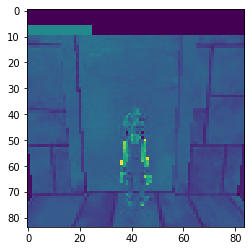

In [5]:
plt.imshow(obs.reshape(84, 84))

In [20]:
for i in range(100):
    obs, reward, done, info = env.step(np.random.randint(54))

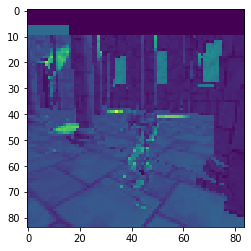

In [21]:
plt.imshow(obs.reshape(84, 84))

In [25]:
brain = env._env.brains[env.brain_name]

In [28]:
dir(brain)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'brain_name',
 'camera_resolutions',
 'from_proto',
 'num_stacked_vector_observations',
 'number_visual_observations',
 'vector_action_descriptions',
 'vector_action_space_size',
 'vector_action_space_type',
 'vector_observation_space_size']

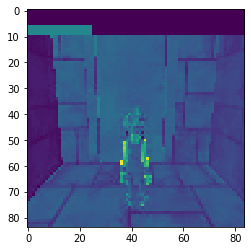

In [4]:
plt.imshow(obs.reshape(84, 84))

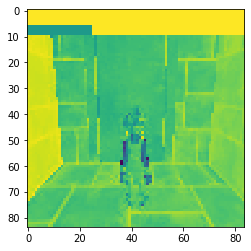

In [5]:
new_obs = np.floor(np.expand_dims(np.mean(obs, axis=2), axis=2)).astype(np.uint8)

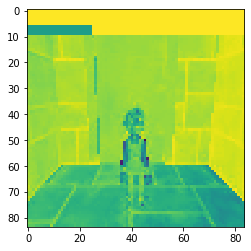

In [25]:
plt.imshow(1-new_obs.reshape(84, 84)/255.)

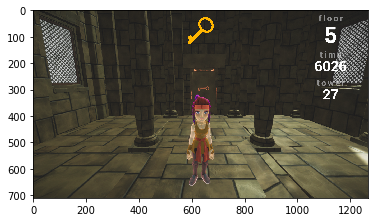

In [6]:
from PIL import Image
import numpy as np

im_frame = Image.open('shot.png')
im = np.array(im_frame)
plt.imshow(im)

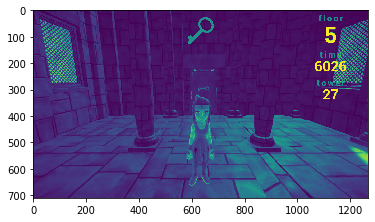

In [9]:
new_obs = np.floor(np.expand_dims(np.mean(im, axis=2), axis=2)).astype(np.uint8)
plt.imshow(new_obs.reshape(710, 1267))

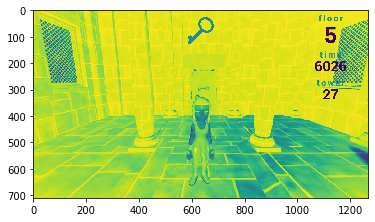

In [12]:
plt.imshow(255 - new_obs.reshape(710, 1267))

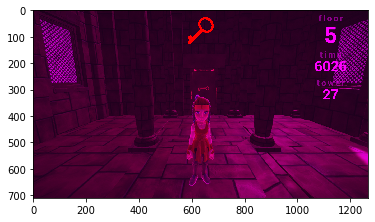

In [25]:
im_frame = Image.open('shot.png')
im = np.array(im_frame)
im[:, :, 1] = 0
plt.imshow(im)

In [37]:
brain = env._env.brains[env.brain_name]

In [40]:
brain.camera_resolutions

[{'height': 168, 'width': 168, 'blackAndWhite': False}]

In [52]:
env._env._resetParameters

{'allowed-rooms': 2.0,
 'dense-reward': 1.0,
 'total-floors': 100.0,
 'agent-perspective': 1.0,
 'tower-seed': -1.0,
 'default-theme': 0.0,
 'allowed-floors': 2.0,
 'allowed-modules': 2.0,
 'lighting-type': 1.0,
 'starting-floor': 0.0,
 'visual-theme': 1.0}

In [ ]:
obs = env.reset()

In [20]:
next_obs, reward, done, info = env.step(1)

In [12]:
obs  = obs /  255.

In [5]:
key = info['brain_info'].vector_observations

In [7]:
key[-1, -2] /= 3000
key

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99833333, 0.        ]])

In [8]:
new = np.append(obs, [1, 0, 0, 0, 0, 0, 3000, 0])
new = new.reshape(1, 7064,)
new = np.append(new, new, axis=0)

In [45]:
new.shape

(2, 7064)

In [10]:
inpobs = obs.reshape(1, 84, 84, 1)
inp = np.append(inpobs, inpobs, axis=0)

In [11]:
inp.shape

(2, 84, 84, 1)

In [103]:
place = tf.placeholder(dtype=tf.float32, shape=(None, 84, 84, 1))

In [104]:
obs = tf.placeholder(dtype=tf.float32, shape=(None,7064,))

In [110]:
scaled = tf.slice(obs, [0, 0], [-1, 84*84])

In [111]:
place.shape, obs.shape, scaled.shape

(TensorShape([Dimension(None), Dimension(84), Dimension(84), Dimension(1)]),
 TensorShape([Dimension(None), Dimension(7064)]),
 TensorShape([Dimension(None), Dimension(7056)]))

In [112]:
tf.reshape(scaled, shape=(-1, 84, 84, 1))

<tf.Tensor 'Reshape_8:0' shape=(?, 84, 84, 1) dtype=float32>

In [113]:
keys = tf.slice(obs, [0, 84*84], [-1, -1])

In [114]:
keys

<tf.Tensor 'Slice_14:0' shape=(?, 8) dtype=float32>

In [116]:
layer = tf.placeholder(dtype=tf.float32, shape=(None,3136))
layer

<tf.Tensor 'Placeholder_9:0' shape=(?, 3136) dtype=float32>

In [117]:
keys

<tf.Tensor 'Slice_14:0' shape=(?, 8) dtype=float32>

In [129]:
tuple((7064,))

(7064,)

In [14]:
from gym.spaces.box import Box

In [25]:
def nature_cnn(scaled_images, **kwargs):
    """
    CNN from Nature paper.
    :param scaled_images: (TensorFlow Tensor) Image input placeholder
    :param kwargs: (dict) Extra keywords parameters for the convolutional layers of the CNN
    :return: (TensorFlow Tensor) The CNN output layer
    """
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=8, stride=4, init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=4, stride=2, init_scale=np.sqrt(2), **kwargs))
    layer_3 = activ(conv(layer_2, 'c3', n_filters=64, filter_size=3, stride=1, init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_3)
    return activ(linear(layer_3, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))

In [27]:
sess.close()

In [26]:
with tf.Session() as sess:
    sess.run(nature_cnn(obs_tensor), feed_dict={obs_tensor:inp})

ValueError: Variable c1/w already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/anaconda3/envs/otc/lib/python3.6/site-packages/stable_baselines/a2c/utils.py", line 127, in conv
    weight = tf.get_variable("w", wshape, initializer=ortho_init(init_scale))
  File "<ipython-input-12-50c6e1640ddc>", line 3, in <module>
    layer_1 = activ(conv(obs_tensor, 'c1', n_filters=32, filter_size=8, stride=4, init_scale=np.sqrt(2)))
  File "/anaconda3/envs/otc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
env = OTCPreprocessing(env, enable_obsnorm=True, obsnorm_mode='pixel', obsnorm_period=2000)

In [5]:
obs = env.reset()
#for i in range(30):
#obs, reward, done, info = env.step(env.action_space.sample())

(84, 84, 1)


AttributeError: 'NoneType' object has no attribute 'shape'

In [6]:
obs.shape

NameError: name 'obs' is not defined

In [6]:
rs_obs = np.expand_dims(obs, 0) / 255.

In [7]:
batch = rs_obs.copy()
for i in range(31):
    new = rs_obs + np.random.random(rs_obs.shape)
    batch = np.append(batch, new, axis=0)
batch = np.append(batch, batch, axis=3)

In [31]:
batch.shape

(32, 84, 84, 2)

In [47]:
obs1 = obs.copy() / 255.
running_pixel_mean = np.random.random(env.observation_space.shape)

In [48]:
obs2 = (running_pixel_mean + obs1) * 1/2

In [57]:
obs2 = ((running_pixel_mean * 1) + obs1) / 2
obs2.shape

(84, 84, 1)

In [68]:
b = np.append(obs1, obs2, axis=2)

In [91]:
c = b.mean(axis=2, keepdims=True)

In [86]:
d = obs2 - np.expand_dims(c, 2)

In [93]:
d.mean()-obs2.mean(), c.mean()

(-0.22925243029971729, 0.22925243029971737)

In [109]:
b[:, :, -1:].shape

(84, 84, 1)

In [103]:
b.mean(), b.std()

(0.22925243029971737, 0.15902233627298448)

In [10]:
inputs = batch.copy() * 10000

In [11]:
slim = tf.contrib.slim
tf.reset_default_graph()
sess = tf.Session()

def reduce_std(x, axis=None, keepdims=False):
    return tf.sqrt(reduce_var(x, axis=axis, keepdims=keepdims))

def mymodel(inputs):
    net = tf.cast(inputs, tf.float32)
    net = tf.div(net, 255.)
    net = slim.conv2d(net, 32, [8, 8], stride=4, trainable=False)
    net = slim.conv2d(net, 64, [4, 4], stride=2, trainable=False)
    net = slim.conv2d(net, 64, [3, 3], stride=1, trainable=False)
    net = slim.flatten(net)
    net = slim.fully_connected(net, 512, trainable=False)
    q_values = slim.fully_connected(net, 54, activation_fn=None, trainable=False)
    return q_values

def pred(inputs):
    net = tf.cast(inputs, tf.float32)
    net = tf.div(net, 255.)
    net = slim.conv2d(net, 32, [8, 8], stride=4, trainable=True)
    net = slim.conv2d(net, 64, [4, 4], stride=2, trainable=True)
    net = slim.conv2d(net, 64, [3, 3], stride=1, trainable=True)
    net = slim.flatten(net)
    net = slim.fully_connected(net, 512, trainable=True)
    q_values = slim.fully_connected(net, 54, activation_fn=None, trainable=True)
    return q_values


data = tf.placeholder("float", shape=batch.shape)
results = mymodel(data)
old_data = tf.placeholder("float", shape=batch.shape)
predicts = pred(old_data)


loss = tf.squared_difference(results, predicts)
loss = tf.reduce_sum(loss, axis=1)
#normalized_loss = tf.divide(loss, reduce_std(loss))
total_loss = slim.losses.mean_squared_error(results, predicts)


train_op = tf.train.AdamOptimizer(.00025).minimize(total_loss)

sess.run(tf.global_variables_initializer())
#rnd_train_op = slim.learning.create_train_op(total_loss, optimizer)

Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.


In [12]:
sess.run(tf.sqrt(tf.nn.moments(loss, 0)[1]), feed_dict={data:inputs, old_data:batch})

95.516884

In [13]:
import numpy as np
np.array([ 13.25101, 134.9473 , 207.69507, 161.99585, 150.17528, 171.86179,
       193.0722 , 175.1009 , 160.06993, 207.2973 , 157.3675 , 193.9255 ,
       163.84152, 147.51643, 212.81459, 228.50793, 171.9607 , 140.81902,
       201.49759, 194.96815, 166.89749, 186.54922, 152.3136 , 195.69202,
       162.11737, 216.28683, 172.25737, 184.89424, 192.1009 , 198.09305,
       175.78708, 127.85109]).std()

37.62854183521793

In [12]:
for i in range(100):
    sess.run(train_op, feed_dict={data:inputs, old_data:batch})

In [14]:
sess.run(results, feed_dict={data:inputs})

array([[-0.0878039 ,  0.72196597, -0.690385  , ..., -0.16994649,
        -1.1732842 , -0.44626325],
       [-1.3635473 ,  0.6443021 , -1.9300433 , ..., -0.86984766,
        -5.4135914 , -1.2137287 ],
       [-0.15769506,  2.685185  , -0.22919285, ..., -1.4306363 ,
        -5.560427  , -1.2545491 ],
       ...,
       [ 3.0219128 ,  4.3628826 , -1.284682  , ..., -1.9630249 ,
        -5.086002  , -0.81472445],
       [ 1.7828431 ,  3.35549   , -2.0639133 , ..., -1.720954  ,
        -4.549235  , -2.4855556 ],
       [ 1.1518321 ,  2.3979094 , -1.5885028 , ..., -1.2036123 ,
        -6.4058657 , -1.6052418 ]], dtype=float32)

In [15]:
sess.run(predicts, feed_dict={old_data:batch})

array([[ 0.45723605,  2.4823058 , -1.8272264 , ..., -1.5131226 ,
        -4.2200913 , -1.6350508 ],
       [ 0.5357837 ,  2.9206703 , -2.1473281 , ..., -1.7822204 ,
        -4.962805  , -1.9234298 ],
       [ 0.5373709 ,  2.9293168 , -2.1526825 , ..., -1.7867126 ,
        -4.976461  , -1.9288226 ],
       ...,
       [ 0.5371451 ,  2.9250188 , -2.150078  , ..., -1.7846568 ,
        -4.9700384 , -1.926426  ],
       [ 0.5372966 ,  2.9284432 , -2.1526666 , ..., -1.7866135 ,
        -4.9757147 , -1.9284141 ],
       [ 0.53670824,  2.9275217 , -2.1519058 , ..., -1.7868333 ,
        -4.9745135 , -1.927914  ]], dtype=float32)

In [16]:
sess.run(total_loss, feed_dict={data:inputs, old_data:batch})

1.1545346

In [24]:
a = tf.random.uniform(loss.shape)
a

<tf.Tensor 'random_uniform_5:0' shape=(32,) dtype=float32>

In [22]:
a = tf.concat([a, loss], axis=0)
a

<tf.Tensor 'concat_2:0' shape=(64,) dtype=float32>

In [30]:
tf.nn.moments(a, 0, keep_dims=True)

(<tf.Tensor 'moments_6/mean:0' shape=(1,) dtype=float32>,
 <tf.Tensor 'moments_6/variance:0' shape=(1,) dtype=float32>)

In [75]:
weights = slim.variable('weights', shape=[10, 10, 3 , 3], initializer=tf.truncated_normal_initializer(stddev=0.1))

In [80]:
slim.get_variables()

[<tf.Variable 'weights:0' shape=(10, 10, 3, 3) dtype=float32_ref>]

In [9]:
tf.random.uniform(batch.shape)

<tf.Tensor 'random_uniform:0' shape=(32, 84, 84, 2) dtype=float32>

In [20]:
a = tf.convert_to_tensor(batch)

In [43]:
a = tf.concat([loss, loss], axis=0)

In [46]:
tf.nn.moments(a, 0)[1]

<tf.Tensor 'moments_3/Squeeze_1:0' shape=() dtype=float32>

In [113]:
state = np.random.rand(84, 84, 1)
state2 = np.random.rand(84, 84, 1)
((state - state2)**2).mean()

0.16616627445598744

In [103]:
state.reshape(1,84,84,1).shape

(1, 84, 84, 1)

In [116]:
state = np.random.rand(84, 84, 1)
state3 = np.expand_dims(state, 0)

In [1]:
import time
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from keras import backend as K
num_cores=6
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0}
                       )

session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
def double(x):
    return np.append(x, x, axis=0)

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=8, activation='relu', input_shape=(84, 84, 1)))
model.add(Conv2D(64, kernel_size=4, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation=None))
model.trainable = False
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.build()

In [32]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=8, activation='relu', input_shape=(84, 84, 1)))
model2.add(Conv2D(64, kernel_size=4, activation='relu'))
model2.add(Conv2D(64, kernel_size=3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation=None))
model2.trainable = True
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model2.build()

In [33]:
state = np.random.rand(84, 84, 1)
state = np.expand_dims(state, 0)
target = model.predict(state)

start = time.time()
for i in range(40):
    pred = model2.predict(state)
    print("Step", i, "loss:", ((target - pred)**2).mean())
    model2.fit(state, target, batch_size=1, verbose=0)
    
print(time.time() - start)

Step 0 loss: 0.004082861
Step 1 loss: 0.9525634
Step 2 loss: 0.12549347
Step 3 loss: 0.02464965
Step 4 loss: 0.011145618
Step 5 loss: 0.0038855239
Step 6 loss: 0.0018866786
Step 7 loss: 0.0014667927
Step 8 loss: 0.0014160266
Step 9 loss: 0.0014431834
Step 10 loss: 0.0014759914
Step 11 loss: 0.0014848739
Step 12 loss: 0.0014735074
Step 13 loss: 0.0014418443
Step 14 loss: 0.0013747422
Step 15 loss: 0.0012298122
Step 16 loss: 0.0009773783
Step 17 loss: 0.001303206
Step 18 loss: 0.00077321246
Step 19 loss: 0.00085658533
Step 20 loss: 0.00088277576
Step 21 loss: 0.00076957664
Step 22 loss: 0.0006126433
Step 23 loss: 0.00054865226
Step 24 loss: 0.00036767896
Step 25 loss: 0.00031136564
Step 26 loss: 0.00026284694
Step 27 loss: 0.00023077014
Step 28 loss: 0.00018559239
Step 29 loss: 0.00013878476
Step 30 loss: 0.00011602624
Step 31 loss: 8.661903e-05
Step 32 loss: 7.0762326e-05
Step 33 loss: 5.4806183e-05
Step 34 loss: 4.54717e-05
Step 35 loss: 3.9054463e-05
Step 36 loss: 3.2079635e-05
Step 3

In [34]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=8, activation='relu', input_shape=(84, 84, 1)))
model2.add(Conv2D(64, kernel_size=4, activation='relu'))
model2.add(Conv2D(64, kernel_size=3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation=None))
model2.trainable = True
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model2.build()

In [35]:

state = np.random.rand(84, 84, 1)
state = np.expand_dims(state, 0)
target = model.predict(state)

double_state = double(double(double(state)))
double_target = double(double(double(target)))
start = time.time()
for i in range(5):
    pred = model2.predict(state)
    print("Step", i, "loss:", ((target - pred)**2).mean())
    model2.fit(double_state, double_target, batch_size=1, verbose=0)
    
print(time.time() - start)

Step 0 loss: 0.005433338
Step 1 loss: 0.0016783832
Step 2 loss: 0.0016416372
Step 3 loss: 0.0013941337
Step 4 loss: 0.00080668204
54.930814266204834


In [8]:
state = np.random.rand(84, 84, 1)

In [10]:
np.tile(state, (32,1,1,1)).shape

(32, 84, 84, 1)

In [133]:
target = model.predict(state3)
pred = model2.predict(state3)

for i in range(10000):
    state = np.random.rand(84, 84, 1)
    state3 = np.expand_dims(state, 0)
    target = model.predict(state3)
    pred = model2.predict(state3)
    if i%100 == 0:
        print("Step", i, "loss:", ((target - pred)**2).mean())
    model2.fit(state3, target, batch_size=1, verbose=0)
    

Step 0 loss: 0.00021432253
Step 100 loss: 0.00024450035
Step 200 loss: 0.0002292646
Step 300 loss: 0.00027518655
Step 400 loss: 0.0002022305
Step 500 loss: 0.00023443482
Step 600 loss: 0.0003092853
Step 700 loss: 0.0002912826
Step 800 loss: 0.00028253673
Step 900 loss: 0.0002549804
Step 1000 loss: 0.00029462605
Step 1100 loss: 0.00024895283
Step 1200 loss: 0.00027393678
Step 1300 loss: 0.00027812496
Step 1400 loss: 0.00025396893
Step 1500 loss: 0.00025443273
Step 1600 loss: 0.00031512478
Step 1700 loss: 0.0002876909
Step 1800 loss: 0.00023357724
Step 1900 loss: 0.000254822
Step 2000 loss: 0.00023101506
Step 2100 loss: 0.00028171059
Step 2200 loss: 0.00022405037
Step 2300 loss: 0.00026168692
Step 2400 loss: 0.0002694803
Step 2500 loss: 0.00026116453
Step 2600 loss: 0.00032874156
Step 2700 loss: 0.0002782803
Step 2800 loss: 0.00030647172
Step 2900 loss: 0.00027881685
Step 3000 loss: 0.00022830267
Step 3100 loss: 0.00031716132
Step 3200 loss: 0.0002510331
Step 3300 loss: 0.0002812971
Step

Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.0040 - acc: 0.0000e+00


In [ ]:
loss = 

In [13]:
import itertools

possible_vals = [range(_num) for _num in branched_action_space]
all_actions = [list(_action) for _action in itertools.product(*possible_vals)]
action_lookup = {_scalar: _action for (_scalar, _action) in enumerate(all_actions)}

In [16]:
Discrete(len(action_lookup))

Discrete(54)

In [17]:
brain.vector_action_space_size

[3, 3, 2, 3]

In [18]:
action_lookup[53]

[2, 2, 1, 2]

In [79]:
obs = env.reset()
for i in range(30):
    obs, reward, done, info = env.step(53)


In [7]:
env.action_meanings

['Movement Forward/Back', 'Camera', 'Jump', 'Movement Left/Right']

In [20]:
action_lookup

{0: [0, 0, 0, 0],
 1: [0, 0, 0, 1],
 2: [0, 0, 0, 2],
 3: [0, 0, 1, 0],
 4: [0, 0, 1, 1],
 5: [0, 0, 1, 2],
 6: [0, 1, 0, 0],
 7: [0, 1, 0, 1],
 8: [0, 1, 0, 2],
 9: [0, 1, 1, 0],
 10: [0, 1, 1, 1],
 11: [0, 1, 1, 2],
 12: [0, 2, 0, 0],
 13: [0, 2, 0, 1],
 14: [0, 2, 0, 2],
 15: [0, 2, 1, 0],
 16: [0, 2, 1, 1],
 17: [0, 2, 1, 2],
 18: [1, 0, 0, 0],
 19: [1, 0, 0, 1],
 20: [1, 0, 0, 2],
 21: [1, 0, 1, 0],
 22: [1, 0, 1, 1],
 23: [1, 0, 1, 2],
 24: [1, 1, 0, 0],
 25: [1, 1, 0, 1],
 26: [1, 1, 0, 2],
 27: [1, 1, 1, 0],
 28: [1, 1, 1, 1],
 29: [1, 1, 1, 2],
 30: [1, 2, 0, 0],
 31: [1, 2, 0, 1],
 32: [1, 2, 0, 2],
 33: [1, 2, 1, 0],
 34: [1, 2, 1, 1],
 35: [1, 2, 1, 2],
 36: [2, 0, 0, 0],
 37: [2, 0, 0, 1],
 38: [2, 0, 0, 2],
 39: [2, 0, 1, 0],
 40: [2, 0, 1, 1],
 41: [2, 0, 1, 2],
 42: [2, 1, 0, 0],
 43: [2, 1, 0, 1],
 44: [2, 1, 0, 2],
 45: [2, 1, 1, 0],
 46: [2, 1, 1, 1],
 47: [2, 1, 1, 2],
 48: [2, 2, 0, 0],
 49: [2, 2, 0, 1],
 50: [2, 2, 0, 2],
 51: [2, 2, 1, 0],
 52: [2, 2, 1, 1],
 53

In [41]:
dir(brain)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'brain_name',
 'camera_resolutions',
 'from_proto',
 'num_stacked_vector_observations',
 'number_visual_observations',
 'vector_action_descriptions',
 'vector_action_space_size',
 'vector_action_space_type',
 'vector_observation_space_size']

In [43]:
brain.vector_action_descriptions

['Movement Forward/Back', 'Camera', 'Jump', 'Movement Left/Right']

In [44]:
brain.vector_action_space_size

[3, 3, 2, 3]

In [45]:
brain.vector_action_space_type

'discrete'

In [78]:
brain.vector_action_space_size = [2, 2, 1, 2]